In [1]:
# import packages
import glob
import numpy as np
import matplotlib.pyplot as plt
import skimage
import cv2

from skimage import io
from skimage.filters import gaussian
from skimage.util import img_as_ubyte
from skimage import morphology
from photutils import Background2D, MedianBackground
from astropy.stats import SigmaClip
from photutils import Background2D, MeanBackground, MedianBackground, BiweightLocationBackground, ModeEstimatorBackground, MMMBackground, SExtractorBackground

%matplotlib inline

In [2]:
### define functions ###
# images padding
def padding_image(img, m):
    row, col = img.shape[:2]
    bottom = img[row-2:row, 0:col]
    mean = cv2.mean(bottom)[0]
    bordersize = int((m-1)/2)
    return cv2.copyMakeBorder(
        img,
        top=bordersize,
        bottom=bordersize,
        left=bordersize,
        right=bordersize,
        borderType=cv2.BORDER_CONSTANT,
        value=[mean, mean, mean])

# image transformation
def transform_image(img, m, row, col):
    cv_img = np.zeros((row, col), dtype=float)
    # calculate image transformation
    for x in range(int((m-1)/2), row-int((m-1)/2)+1):
        for y in range(int((m-1)/2), col-int((m-1)/2)+1):
            g_bar = sum(sum(np.float32(img[x-int((m-1)/2):x+int((m-1)/2)+1, y-int((m-1)/2):y+int((m-1)/2)+1])))/m**2
            if g_bar != 0.0:
                cv_img[x,y] = np.sqrt(sum(sum((np.float32(img[x-int((m-1)/2):x+int((m-1)/2+1), y-int((m-1)/2):y+int((m-1)/2)+1])-g_bar)**2))/m**2)/g_bar
            else:
                cv_img[x,y] = 0.0
    return cv_img

# image thresholding
def threshold_image(img, K):
    # find line thresholds in x and y
    row, col = np.shape(img)
    x_Th = np.zeros(row)
    for x in range(row):
        x_Th[x] = np.mean(img[x,:])*K
    y_Th = np.zeros(col)   
    for y in range(col):
        y_Th[y] = np.mean(img[:,y])*K
    
    # line thresholding using OR
    lineTh_img = np.ndarray(np.shape(img), dtype=float)
    for x in range(row):
        for y in range(col):
            if img[x,y] <= x_Th[x] and img[x,y] <= y_Th[y]:
                lineTh_img[x,y] = 0.0
            else: 
                lineTh_img[x,y] = 1.0
    return lineTh_img

In [3]:
# load image data from a plate 
file_list_BF = glob.glob("./H1/H1_01_2_1_Bright Field_*.tif")
file_list_BF.sort()

In [4]:
# set the index of image 
T = 2

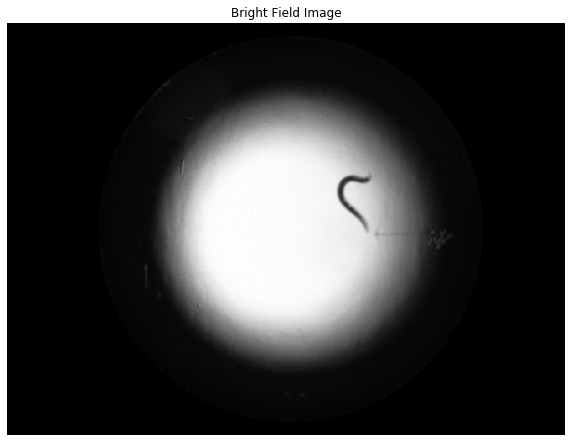

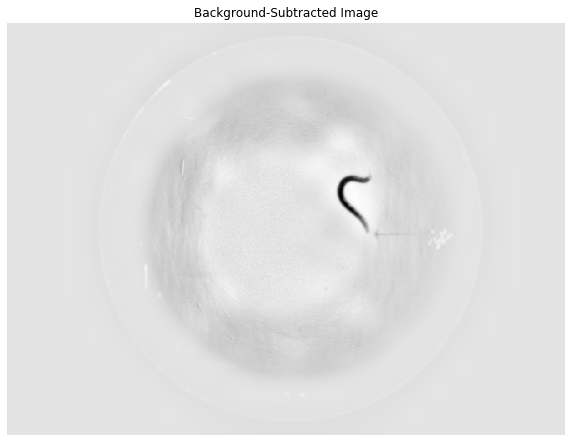

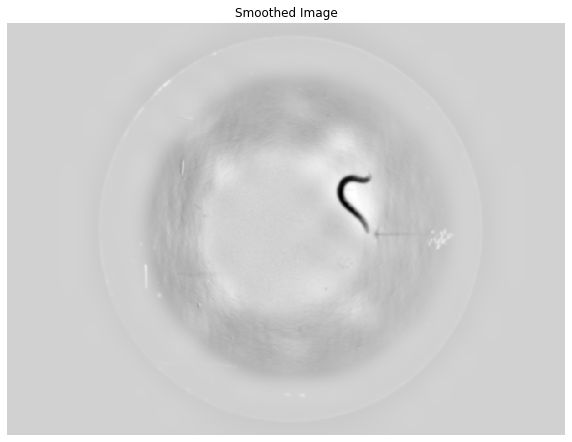

In [5]:
# covert image into gray scale [0, 255]
img = img_as_ubyte(io.imread(fname=file_list_BF[T], as_gray=True))

# show example image
fig = plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='Greys_r')
plt.title('Bright Field Image')
plt.axis('off')
plt.show()

# define background estimators
bkg_estimator = MeanBackground()

# estimate background (background or the background noise varies across the image)
box_size = (50, 50)
filter_size= (3, 3)
sigma_clip = SigmaClip(sigma=5)
# estimate background (background or the background noise varies across the image)
bkg = Background2D(img, box_size, filter_size=filter_size,
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

# subtracted background
subtracted_bkg_img = cv2.normalize(np.float32(img)-bkg.background, None, 0, 255, cv2.NORM_MINMAX)

# show subtracted background
fig = plt.figure(figsize=(10, 10))
plt.imshow(subtracted_bkg_img, cmap='Greys_r')
plt.title('Background-Subtracted Image')
plt.axis('off')
plt.show()

# noise reduction using Gaussian filter
smoothed_img = gaussian(subtracted_bkg_img, sigma=1, mode='reflect')

# show smoothed image
fig = plt.subplots(figsize=(10, 10))
plt.imshow(smoothed_img, cmap=plt.cm.gray)
plt.title('Smoothed Image')
plt.axis('off')
plt.show()

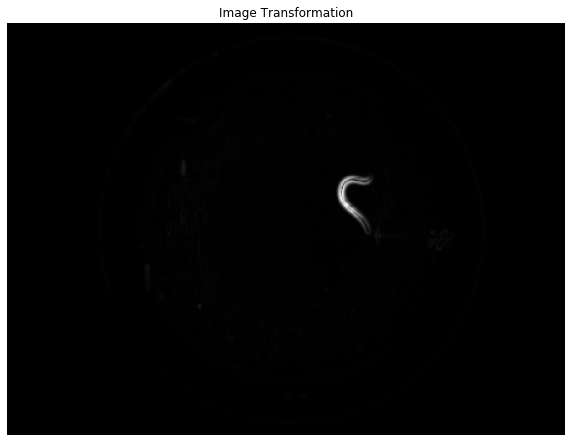

In [6]:
# set local sliding window size
m = 5                    

# pad images 
padded_img = padding_image(smoothed_img, m)

# calculate image transformation      
cv_img = transform_image(padded_img, m, img.shape[0], img.shape[1])
    
# normalized into the range [0,255]
transformed_img = np.uint8(cv2.normalize(cv_img, None, 0, 255, cv2.NORM_MINMAX))

# show transformed image
fig = plt.figure(figsize=(10, 10))
plt.imshow(transformed_img, cmap='Greys_r')
plt.title('Image Transformation')
plt.axis('off')
plt.show()

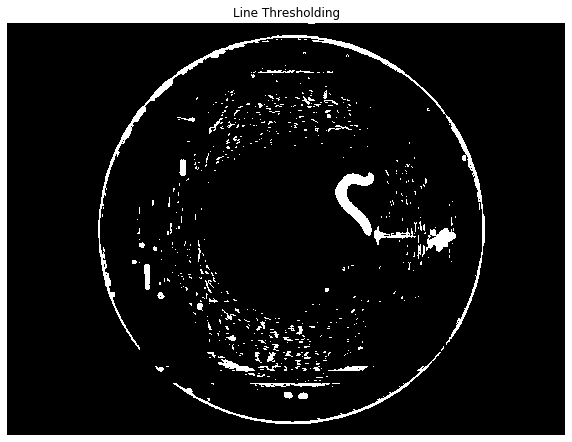

In [7]:
# set constant for line thresholding
K = 5.5 

# line thresholding
lineTh_img = threshold_image(transformed_img, K)

# normalized into the range [0,255]
seg_img = np.uint8(cv2.normalize(lineTh_img, None, 0, 255, cv2.NORM_MINMAX)) 

# show thresholding image
fig = plt.figure(figsize=(10,10))
plt.imshow(seg_img, cmap='Greys_r')
plt.title('Line Thresholding')
plt.axis('off')
plt.show()

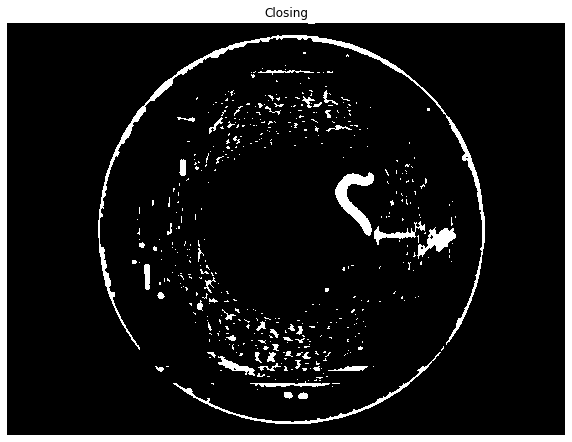

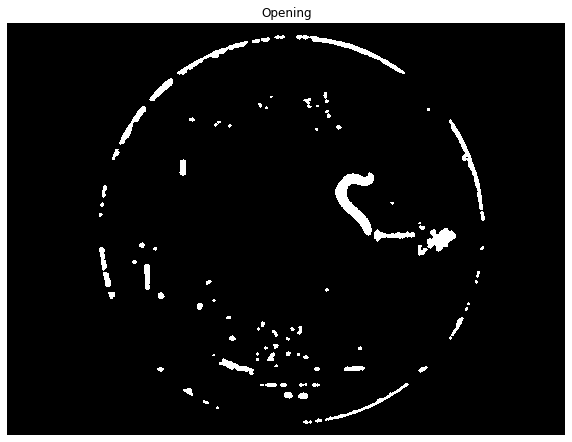

In [8]:
# define structural elements | MORPH_CROSS | MORPH_RECT | MORPH_ELLIPSE
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (5,5))

# mathematical morphology using closing operation 
closing_img = cv2.morphologyEx(seg_img, cv2.MORPH_CLOSE, kernel)
# show results
fig = plt.subplots(figsize=(10, 10))
plt.imshow(closing_img, cmap=plt.cm.gray)
plt.title('Closing')
plt.axis('off')
plt.show()

# define structural elements | MORPH_CROSS | MORPH_RECT | MORPH_ELLIPSE
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
# mathematical morphology using opening operation 
opening_img = cv2.morphologyEx(closing_img, cv2.MORPH_OPEN, kernel)
# show results
fig = plt.subplots(figsize=(10, 10))
plt.imshow(opening_img, cmap=plt.cm.gray)
plt.title('Opening')
plt.axis('off')
plt.show()

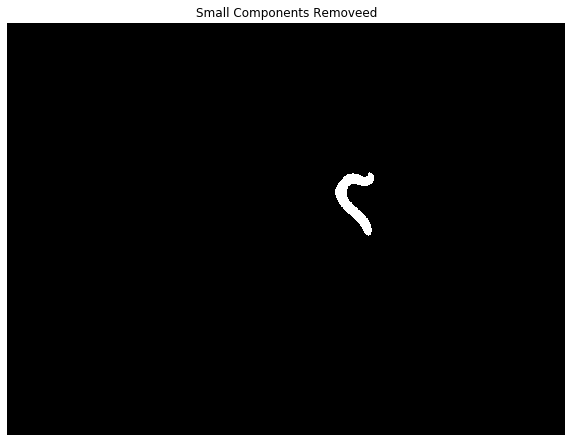

In [9]:
# find all connected components
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(opening_img, connectivity=8)

# connectedComponentswithStats yields every seperated component with information on each of them, such as size
# taking out the background which is also considered a component
sizes = stats[1:, -1]; nb_components = nb_components - 1

# set minimum and maximum size of particles to keep (number of pixels)
min_size = 2500
max_size = 5500  

# remove small objects
removed_img = np.zeros((output.shape))
# for every component in the image, keep it only if it's above min_size
for i in range(0, nb_components):
    if sizes[i] >= min_size and sizes[i]<=max_size:
        removed_img[output == i + 1] = 255

# show results
fig = plt.subplots(figsize=(10, 10))
plt.imshow(removed_img, cmap=plt.cm.gray)
plt.title('Small Components Removeed')
plt.axis('off')
plt.show()

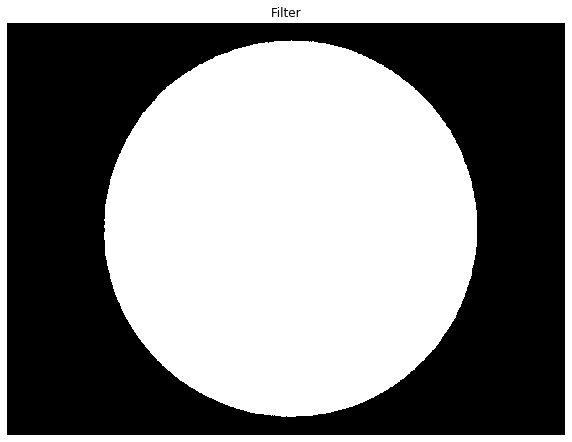

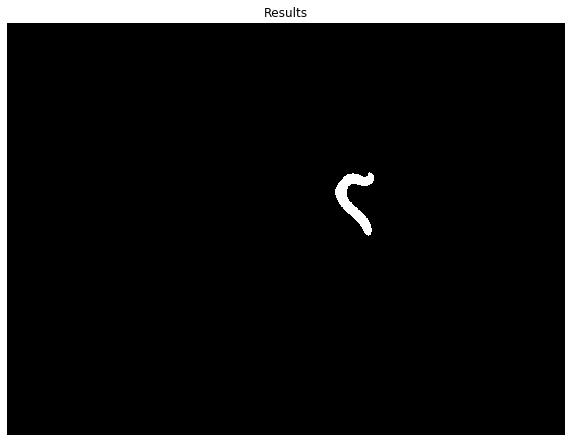

In [10]:
# thresholding lighting field
ret, thresh_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)

# define structural elements | MORPH_CROSS | MORPH_RECT | MORPH_ELLIPSE
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))

# opening
thresh_opening = cv2.morphologyEx(thresh_img, cv2.MORPH_OPEN, kernel)

# erosion
thresh_erosion = cv2.erode(thresh_opening, kernel, iterations=2)
# show results
fig = plt.subplots(figsize=(10, 10))
plt.imshow(thresh_erosion, cmap=plt.cm.gray)
plt.title('Filter')
plt.axis('off')
plt.show()

# apply filter 
result_img = np.multiply(thresh_erosion/255, img_as_ubyte(removed_img/255))
# show results
fig = plt.subplots(figsize=(10, 10))
plt.imshow(result_img, cmap=plt.cm.gray)
plt.title('Results')
plt.axis('off')
plt.show()

In [11]:
# save to file
io.imsave('./H1/H1_01_2_1_T'+ str(T) + '.jpg', result_img.astype(np.uint8), check_contrast=False)